## Job Reports 2023
### Table of Contents
1. Text cleaning and extraction
1. Wordcloud
1. Sentiment Analysis

In [9]:
import pandas as pd
import os
import json
import pandas as pd
import numpy as np
import glob
import re
import sys

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
np.set_printoptions(threshold=sys.maxsize)


In [10]:
companies = {
    '1': 'Safaricom',
    '2': 'UN, United Nations',
    '3': 'KenGen, Ken Gen',
    '4': 'Google',
    '5': 'Cocacola, Coca-cola, Coca cola',
    '6': 'pwc',
    '7': 'Deloitte',
    '8': 'esri',
    '9': 'Amref',
    '10': 'Microsoft',
    '11': 'Airtel',
    '12': 'KPC, Kenya Pipeline Company',
    '13': 'KPA, Kenya Ports Authority',
    '14': 'Eabl',
    '15': 'KRA, Kenya Revenue Authority',
    '16': 'Kplc, Kenya power company',
    '17': 'Toyota',
    '18': 'IBM',
    '19': 'KAA',
    '20': 'ILRI',
    '21': 'SportPesa',
    '22': 'Betika',
    '23': 'GM, General Motors',
    '24': 'Davis Shirtliff',
    '25': 'KWAL',
    '26': 'Andela',
    '27': 'Unilever',
    '28': 'Red Cross'
}


Export tweets (json format)

In [11]:

# f = open('./dayta/1-json.json')
arr = []
path_to_json = './2023-dayta/'
json_pattern = os.path.join(path_to_json, '*.json')
file_list = glob.glob(json_pattern)

# print(file_list)

for file in file_list:
    with open(file) as f:
        temp = json.load(f)
        for line in temp['data']:
            arr.append(line)


df = pd.DataFrame(data=arr)
# save to csv
df.to_csv('./out/collated.csv')

df = df[['text', 'created_at']]

# df.head(100)


#### Text Cleaning and Extraction

##### Pre-processing

In [12]:
txt_lower = df['text'].str.lower()
txt_l_cln = txt_lower.str.replace(
    "\@wanjikureports", "")  # replace wanjiku mentions
# replace ordered listings e.g. 1., 2. etc
txt_l_cln2 = txt_l_cln.str.replace("(\n*\d\.)", '')
narr = txt_l_cln2.to_numpy()


**Pseudocode**

Each listitem in list
- Remove all stop words
- Split all words/numbers
- Check whether word in company list, if in list add to output var -> use eigenvalues, check for closeness of word
- check each # with company list key, add value to output list

In [13]:
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = list(get_stop_words('en'))  # About 900 stopwords
nltk_words = list(stopwords.words('english'))  # About 150 stopwords
stop_words.extend(nltk_words)



In [15]:
from difflib import SequenceMatcher
import jellyfish

def similar(a, b):
    return jellyfish.jaro_distance(a, b)  # prob threshhold set at 0.75
    # return SequenceMatcher(None, a, b).ratio()


def returnFromNumeric(numstr):
    if 1 <= int(numstr) <= 28:
        splt = companies[numstr].split(',')
        return splt[0]

# https://stackoverflow.com/questions/51217909/removing-all-emojis-from-text


def replaceEmoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U0001F1F2-\U0001F1F4"  # Macau flag
                               u"\U0001F1E6-\U0001F1FF"  # flags
                               u"\U0001F600-\U0001F64F"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U0001F1F2"
                               u"\U0001F1F4"
                               u"\U0001F620"
                               u"\u200d"
                               u"\u2640-\u2642"
                               "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)


def returnFromStr(thestr):
    output = None

    for val in companies.values():
        splt = val.split(',')

        selected = splt[0]
        prob = similar(thestr, splt[0].strip().lower())
        prob2 = 0
        
        if len(splt) > 1:
            prob2 = similar(thestr, splt[1].strip().lower())
            
        prob = prob2 if prob2 > prob else prob
        
#         apparently, as per test below kenya_ports is closer to kplc than kpa!
#         print(similar('kenya_ports', 'Kenya Ports authority'.lower()))
#         print(similar('kenya_ports', 'Kenya power'.lower()))
#         Capture manually
        if selected.lower() == 'kplc' and 'port' in thestr:
            prob = 0
        
        if thestr.lower() == 'kenya':
            prob = 0

        if prob >= .75:
            if output is not None:
                prev_prob = similar(thestr, output.lower())
                if prob > prev_prob:
                    output = selected
            else:
                output = selected
                    
#     if output is not None:
#         print('<b>Tumetoa: {}</b>'.format(output))

    return output


Challenges:
Output error e.g. was replacing UN for Uniliver output!
Ensuring stopwords dont match e.g. 'i', 'to'

In [16]:
similar('@'.lower(), 'google'.lower())

0.0

In [17]:
# #test sample outputs 
# sentence_arr = ['kenya_ports']
# for w in sentence_arr:
#     returnFromStr(w)

Challenges resolved hopefully!

>  Original implementation

    output_arr = []
    # test = narr[:5]

    for i, sentence in enumerate(narr):
        internal_arr = []
    #     print(i)
        if i not in [146, 370]:
            final_tokens = []
    #         tokens = [word for word in word_tokenize(sentence) if word.lower() == 'un' and not word in stopwords.words()] 
            tokens = word_tokenize(sentence)
            for tkn in tokens:
                if tkn.lower() == 'un':
                    final_tokens.append(tkn)
                else:
                    if tkn not in stopwords.words():
                        final_tokens.append(tkn)
                
                
    #         print('\n----------------------------\n{} {} {}\n---------------------------'.format(i, sentence, tokens))
            
            for token in final_tokens:
                if token.isnumeric():
                    internal_arr.append(returnFromNumeric(token))
                else:
                    ret_str = returnFromStr(token)
    #                 print(ret_str)
                    internal_arr.append(ret_str)
                    
            print(i, sentence, final_tokens, internal_arr, '\n')
        
        output_arr.append(list(set(internal_arr)))
        
        
    #flatten output_arr
    output_arr = [element for sublist in output_arr for element in sublist]

    len(output_arr)
    
    # speed: ~60secs

> New implementation
> 
> source: https://towardsdatascience.com/applying-python-multiprocessing-in-2-lines-of-code-3ced521bac8f

#### Py Multiprocessing

In [18]:
from multiprocessing import Pool
import time
start_time = time.time()

final_tokens_arr = []

def prepare_token(the_tuple):
    idx = the_tuple[0]
    sentence = the_tuple[1]

    if idx not in [146, 370]:
        final_tokens = []
        tokens = word_tokenize(sentence)
        for tkn in tokens:
            if tkn.lower() == 'un': #add un since it will be removed by stopwords
                final_tokens.append(tkn)
            else:
                if tkn not in stopwords.words():
                    final_tokens.append(tkn)
        
        # final_tokens_arr.append(final_tokens)
        return final_tokens

with Pool() as mp_pool:
    sentences = enumerate(narr)
    final_tokens_arr = mp_pool.map(prepare_token, sentences)
    

print(time.time() - start_time, 'secs')
# final_tokens_arr

24.144340991973877 secs


#### Asyncio

- https://stackoverflow.com/questions/42231161/asyncio-gather-vs-asyncio-wait

In [10]:
# pip install asyncio

In [11]:
'''
import asyncio 
import time
start_time = time.time()

async def prepare_token_async(idx, sentence):
    # idx = the_tuple[0]
    # sentence = the_tuple[1]

    if idx not in [146, 370]:
        final_tokens = []
        tokens = word_tokenize(sentence)
        for tkn in tokens:
            if tkn.lower() == 'un': #add un since it will be removed by stopwords
                final_tokens.append(tkn)
            else:
                if tkn not in stopwords.words():
                    final_tokens.append(tkn)
        
        # final_tokens_arr.append(final_tokens)
        return final_tokens

async def my_main():
    sentences = list(narr)

    tasks = [prepare_token_async(idx,sentence) for idx, sentence in enumerate(narr)]

    final_tokens_arr_async = await asyncio.wait(tasks)

    print(time.time() - start_time, 'secs')
    print(final_tokens_arr_async)

    # ab = await asyncio.gather(
    #     prepare_token_async(0,sentences[0]),
    #     prepare_token_async(1,sentences[1]),
    # )

    # print (ab)

await my_main()

'''

56.75341320037842 secs
({<Task finished coro=<async-def-wrapper.<locals>.prepare_token_async() done, defined at <ipython-input-11-2c70f3d37c2d>:8> result=['@', 'kenyaredcross', '🙏']>, <Task finished coro=<async-def-wrapper.<locals>.prepare_token_async() done, defined at <ipython-input-11-2c70f3d37c2d>:8> result=['@', 'eabl_plc', '....', 'specifically', 'interested', 'working', ...]>, <Task finished coro=<async-def-wrapper.<locals>.prepare_token_async() done, defined at <ipython-input-11-2c70f3d37c2d>:8> result=['@', '_crazynairobian', '@', 'safaricomplc', '@', 'kcbgroup', ...]>, <Task finished coro=<async-def-wrapper.<locals>.prepare_token_async() done, defined at <ipython-input-11-2c70f3d37c2d>:8> result=['@', 'microsoft']>, <Task finished coro=<async-def-wrapper.<locals>.prepare_token_async() done, defined at <ipython-input-11-2c70f3d37c2d>:8> result=['@', 'un', ',', '@', 'ibm', ',', ...]>, <Task finished coro=<async-def-wrapper.<locals>.prepare_token_async() done, defined at <ipytho

#### **Ray Parallel Processing

Challenge installing ray on py 3.7.13 vm

In [12]:
# pip install ray

In [13]:

# pip install -U /Users/daudi/Downloads/ray-3.0.0.dev0-cp37-cp37m-macosx_10_15_intel.whl

> pip install https://s3-us-west-2.amazonaws.com/ray-wheels/master/ba6cebe30fab6925e5b2d9e859ad064d53015246/ray-3.0.0.dev0-cp37-macosx_10_15_x86_64.whl

> **Notes:**
>
> Previous code execution times were ~60secs, the new implementation is ~20secs representing a 3-fold increase in speed
>

Further speed improvements:
- Look into algorithm vectorization - can the algorithm be written for matrix multplication?
- Look into converting stopwords list into set, to speed up in for...in lookup 
  - https://stackoverflow.com/questions/20234935/python-in-operator-speed
  - https://stackoverflow.com/questions/66077177/is-there-a-way-to-take-advantage-of-multiple-cpu-cores-with-asyncio
- Ray 
    - https://medium.com/distributed-computing-with-ray/how-to-scale-python-multiprocessing-to-a-cluster-with-one-line-of-code-d19f242f60ff
    - https://www.dominodatalab.com/blog/spark-dask-ray-choosing-the-right-framework
    - https://stackoverflow.com/questions/64247663/how-to-use-python-ray-to-parallelise-over-a-large-list
    - https://towardsdatascience.com/10x-faster-parallel-python-without-python-multiprocessing-e5017c93cce1#:~:text=On%20a%20machine%20with%2048%20physical%20cores%2C%20Ray%20is%206x,on%20fewer%20than%2024%20cores.
- Fugue
    - https://towardsdatascience.com/introducing-fugue-reducing-pyspark-developer-friction-a702230455de
    

In [14]:
output_arr = []
# internal_arr = []

for token_arr in final_tokens_arr:
    # print(token_arr)
    if token_arr is not None and len(token_arr) > 0:
        internal_arr = []
        for token in token_arr:
            if token.isnumeric():
                internal_arr.append(returnFromNumeric(token))
            else:
                ret_str = returnFromStr(token)
            #                 print(ret_str)
                internal_arr.append(ret_str)
        
        # print(token_arr, internal_arr)
        output_arr.append(list(set(internal_arr)))

output_arr = [element for sublist in output_arr for element in sublist]

len(output_arr)

2296

In [15]:
finalarr = [txt for txt in output_arr if txt is not None]

# finalarr


In [16]:
corpus = "; ".join(finalarr)
# corpus


In [17]:
cols = ['Companies']
df_out = pd.DataFrame(finalarr, columns=cols)
df_grp = df_out.groupby(cols).size().reset_index(name='Count')


In [18]:
# import dtale
df_grp.sort_values(by='Count', ascending=False)

# dtale.show(df_grp)

,Companies,Count
24,UN,195
7,Eabl,123
17,KenGen,95
9,Google,69
21,Safaricom,68
1,Amref,60
20,Red Cross,58
25,Unilever,57
22,SportPesa,47
6,Deloitte,46


In [19]:
## Totally use-t-less cos this aint used in wordcloud
# for idx in df_grp.index:
#     df_grp['Companies'][idx] = "{} [{}]".format(
#         df_grp['Companies'][idx].upper(), df_grp['Count'][idx])


In [20]:
finalarr = [w for w in finalarr]

> A weakness of wordcloud is text-case **must** be considered. Some letters look bigger than they should in a wordcloud, misrepresenting the actual size of a word


 WanjikuReports Jobs Desiriability Index 2023 



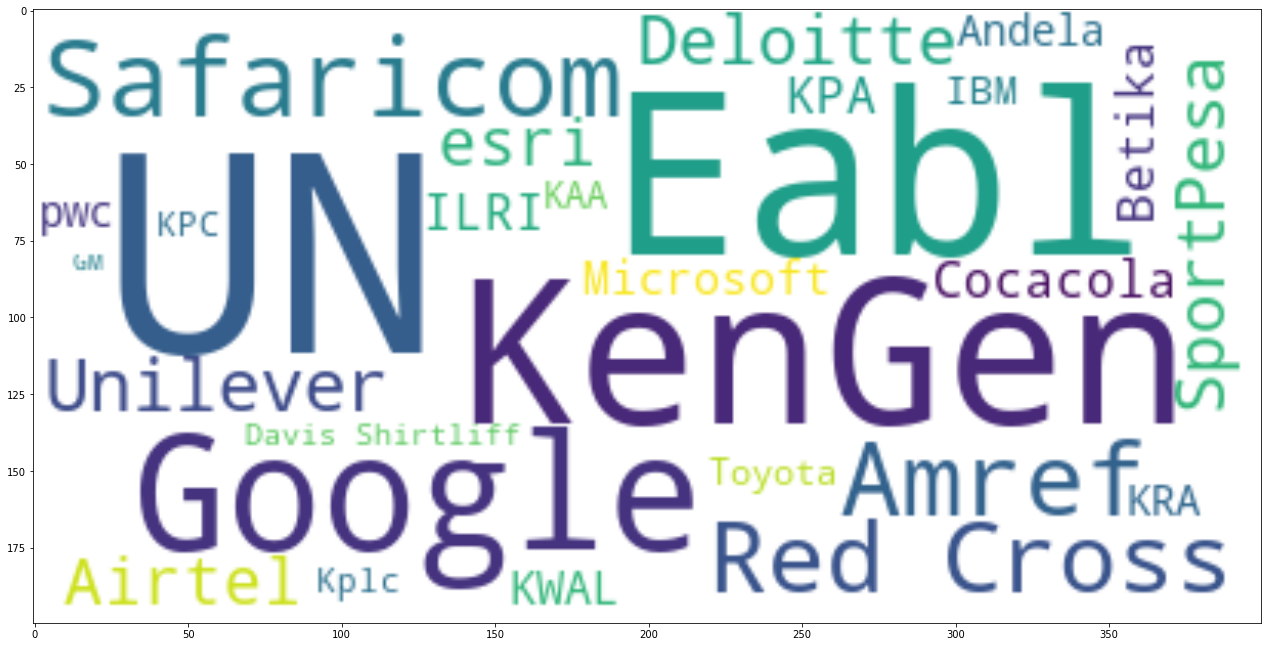

In [23]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import matplotlib.pyplot as plt

word_could_dict = Counter(finalarr)

print('\n\033[1m WanjikuReports Jobs Desiriability Index 2023 \033[1m\n')

wordcloud = WordCloud(background_color="white").generate_from_frequencies(
    word_could_dict)  # .generate(corpus) #.generate_from_frequencies(word_could_dict)
# Post processing
# ii. plot word cloud model
plt.figure(figsize=(22, 22))
plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
plt.savefig('jobs_2023-2.png')
plt.show()




#### Notes
<!-- Its important to note changes to metrics the last 3 days - Amref moved from 2nd to 3rd etc -->

**Note** 

- these interpretations are time-bound and decay over time hence it's important to keep updating this data
- aggresively check on the error rates - these can be high


Save to csv

In [22]:
df_grp.sort_values(by='Count', ascending=False).to_csv('./out/sortedout.csv')
